In [4]:
!pip install osmnx

Map downloaded: 49 nodes, 105 edges.


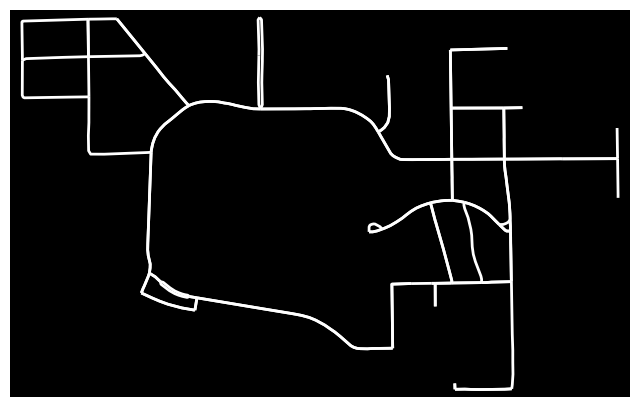

In [ ]:
import osmnx as ox
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


# Download the graph
# network_type='drive' excludes walking paths. Change to 'all' if you want sidewalks.
place_name = "Georgia Institute of Technology"
G = ox.graph_from_place(place_name, network_type="drive")

# Project graph to UTM (meters) instead of Lat/Lon
# This is crucial for defining our "20m radius" later.
G_proj = ox.project_graph(G)

print(f"Map downloaded: {len(G_proj.nodes)} nodes, {len(G_proj.edges)} edges.")

# Plot the graph
# This shows the raw graph structure (Intersections = Nodes, Roads = Edges)
fig, ax = ox.plot_graph(
    G_proj,
    node_size=0,
    edge_color="w",
    edge_linewidth=2,
    bgcolor="k",
    show=False,
    close=False,
)

Creating grid of 3224x2013 pixels (0.5m/px)


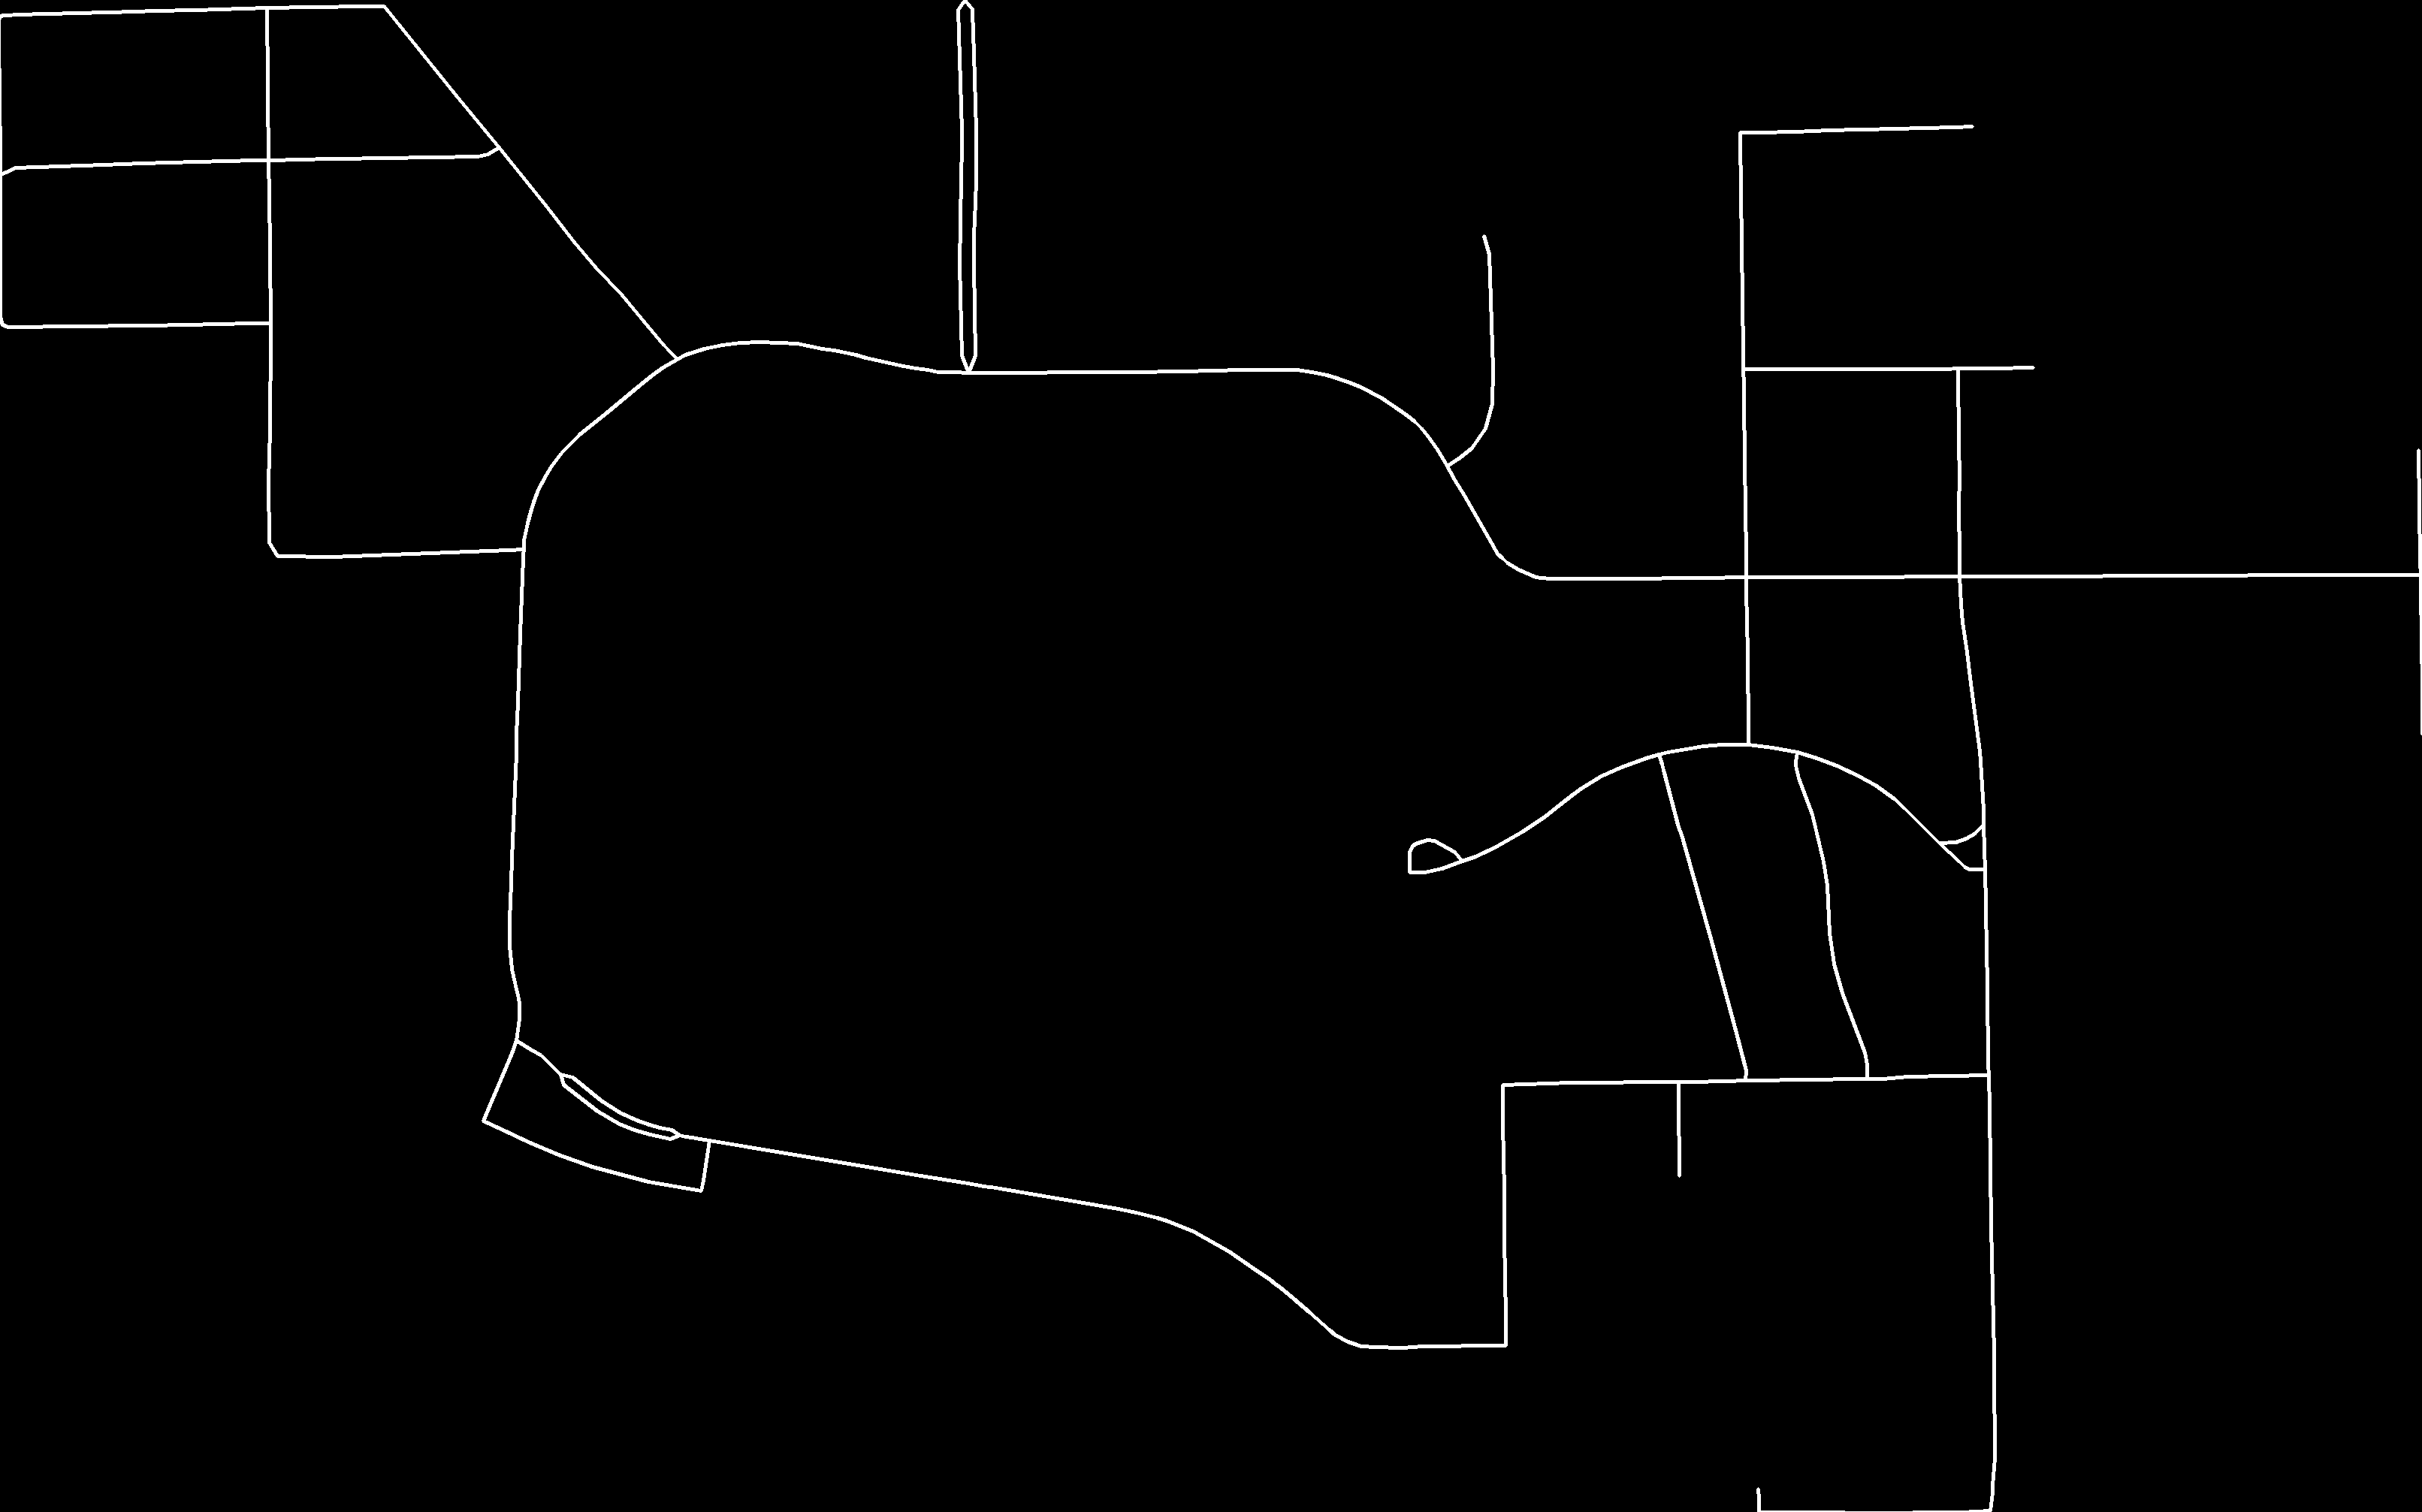

In [ ]:
# 1. Get the bounding box of the campus in meters
nodes, edges = ox.graph_to_gdfs(G_proj)
min_x, min_y, max_x, max_y = nodes.total_bounds
resolution = 0.5  # meters per pixel

# Calculate image dimensions based on resolution
width = int((max_x - min_x) / resolution)
height = int((max_y - min_y) / resolution)
print(f"Creating grid of {width}x{height} pixels ({resolution}m/px)")

# Create a blank black image
# 0 = Obstacle/Non-driveable, 255 = Road/Driveable
grid = np.zeros((height, width), dtype=np.uint8)

# Draw every road/path segment
for _, edge in edges.iterrows():
    # Extract the geometry (LineString) of the road
    if "geometry" in edge:
        coords = list(edge["geometry"].coords)
    else:
        # If no geometry, use node positions
        u_node = nodes.loc[edge.name[0]]
        v_node = nodes.loc[edge.name[1]]
        coords = [(u_node.x, u_node.y), (v_node.x, v_node.y)]

    # Convert UTM coordinates to Pixel coordinates
    pixel_coords = []
    for x, y in coords:
        px = int((x - min_x) / resolution)
        # We subtract from height because image Y starts at top
        py = height - int((y - min_y) / resolution)
        pixel_coords.append([px, py])

    # Draw the line
    pts = np.array(pixel_coords, np.int32).reshape((-1, 1, 2))
    # thickness=4 at 0.5m/px makes roads ~2 meters wide
    cv2.polylines(grid, [pts], isClosed=False, color=255, thickness=4)

# Save metadata (crucial for Phase 2)
metadata = {
    "min_x": min_x,
    "min_y": min_y,
    "resolution": resolution,
    "height": height,
    "width": width,
}

# Show a preview
cv2_imshow(cv2.resize(grid, (3224, 2013)))
cv2.waitKey(0)
cv2.destroyAllWindows()